## Preprocessing

In [2]:
import pandas as pd
import numpy as np
from tabulate import tabulate
import random
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Dense, Flatten, BatchNormalization, Activation, Add
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import ModelCheckpoint

In [3]:
def encode_board_state(board_state_str):
    board_array = np.zeros((8, 8, 3))
    for i, char in enumerate(board_state_str):
        row, col = divmod(i, 8)
        if char == 'w':
            board_array[row, col, 0] = 1
        elif char == 'b':
            board_array[row, col, 1] = 1
        else:
            board_array[row, col, 2] = 1
    return board_array

def encode_policy_updated(visit_counts_str, player, board_size=8, max_moves_per_square=3):
    policy = np.zeros((board_size * board_size * max_moves_per_square))

    if not isinstance(visit_counts_str, str):
        return policy.flatten()

    moves = visit_counts_str.split(';')
    total_visits = 0
    move_counts = {}

    for move in moves:
        parts = move.rsplit(',', 1)
        if len(parts) != 2:
            continue
        move_part, count_part = parts
        try:
            visit_count = int(count_part)
            move_coords = move_part.split(':')
            if len(move_coords) != 2:
                continue
            old_pos = tuple(map(int, move_coords[0].split(',')))
            new_pos = tuple(map(int, move_coords[1].split(',')))
            move_index = calculate_move_index((old_pos, new_pos), player, board_size, max_moves_per_square)
            if move_index >= 0:
                move_counts[move_index] = move_counts.get(move_index, 0) + visit_count
                total_visits += visit_count
        except ValueError:
            continue

    if total_visits == 0:
        return policy.flatten()

    for move_index, count in move_counts.items():
        policy[move_index] = count / total_visits

    return policy

def calculate_move_index(move_key, player, board_size, max_moves_per_square):
    old_pos, new_pos = move_key
    base_index = (old_pos[0] * board_size + old_pos[1]) * max_moves_per_square

    row_diff = new_pos[0] - old_pos[0]
    col_diff = new_pos[1] - old_pos[1]

    move_type_offset = -1
    if player == 'w' and row_diff == -1 or player == 'b' and row_diff == 1:
        if col_diff == -1:
            move_type_offset = 0  # Diagonal left
        elif col_diff == 0:
            move_type_offset = 1  # Straight
        elif col_diff == 1:
            move_type_offset = 2  # Diagonal right

    return base_index + move_type_offset if move_type_offset != -1 else -1


def backpropagate_values_revised(data):
    for game_id in data['Game Number'].unique():
        game_data = data[data['Game Number'] == game_id]
        terminal_state = game_data.iloc[-1]
        game_result = terminal_state['Game Result']

        if pd.isna(game_result):
            continue

        for idx in game_data.index[:-1]:  # Exclude the terminal state
            current_player = game_data.at[idx, 'Player to Move']
            value = 1 if current_player == game_result else -1
            data.at[idx, 'value'] = value

    data['value'].fillna(0, inplace=True)
    return data

def preprocess_for_alphazero(file_path):
    data = pd.read_csv(file_path)
    data_with_values = backpropagate_values_revised(data)
    non_terminal_data = data_with_values[data_with_values['Move to Take'] != 'over']

    non_terminal_data['boardstate'] = non_terminal_data['Board State'].apply(encode_board_state)
    non_terminal_data['policy'] = non_terminal_data.apply(lambda row: encode_policy_updated(row['Visit Counts'], row['Player to Move']), axis=1)

    final_data_revised = non_terminal_data[['boardstate', 'policy', 'value']]
    return final_data_revised


In [4]:
# do preprocessing
file_path = '/content/drive/MyDrive/AlphaZero/full.csv'
preprocessed_data = preprocess_for_alphazero(file_path)

<ipython-input-3-1d1ab2f76e99>:93: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_terminal_data['boardstate'] = non_terminal_data['Board State'].apply(encode_board_state)
<ipython-input-3-1d1ab2f76e99>:94: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_terminal_data['policy'] = non_terminal_data.apply(lambda row: encode_policy_updated(row['Visit Counts'], row['Player to Move']), axis=1)


In [4]:
preprocessed_data.shape

(51334, 3)

In [ ]:
display(preprocessed_data.head(5))

In [6]:
policy_list = list(preprocessed_data['policy'].iloc[0])
# Calculate the sum of the values in the list
sum_of_values = sum(policy_list)

# Calculate the number of non-zero elements in the list
non_zero_count = sum(1 for value in policy_list if value != 0)

sum_of_values, non_zero_count

(1.0, 22)

## Model (ResNet Architecture)


In [6]:
# Check if GPU is available
#device_name = tf.test.gpu_device_name()
#if device_name != '/device:GPU:0':
#    raise SystemError('GPU device not found')
#print('Found GPU at: {}'.format(device_name))

class AlphaZeroModel:
    def __init__(self, board_shape, policy_shape, learning_rate=0.001, number_of_resnet_blocks=100):
        self.board_shape = board_shape
        self.policy_shape = policy_shape
        self.learning_rate = learning_rate
        self.number_of_resnet_blocks = number_of_resnet_blocks
        self.model = self._build_model()

    def _build_model(self):
        input_board = Input(shape=self.board_shape)

        # Initial convolutional layer
        x = Conv2D(64, (3, 3), padding='same')(input_board)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)

        # Adding ResNet blocks
        for _ in range(self.number_of_resnet_blocks):
            x = self.resnet_block(x, 64, (3, 3))

        # Flatten the output for policy and value heads
        conv_flat = Flatten()(x)

        # Policy head
        policy_logits = Dense(self.policy_shape, activation='softmax', name='policy')(conv_flat)

        # Value head
        value_fc = Dense(64, activation='relu')(conv_flat)
        value_logits = Dense(1, activation='tanh', name='value')(value_fc)

        # Create the model
        model = Model(inputs=input_board, outputs=[policy_logits, value_logits])

        return model

    def resnet_block(self, input_layer, filters, kernel_size):
        x = Conv2D(filters, kernel_size, padding='same')(input_layer)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)

        x = Conv2D(filters, kernel_size, padding='same')(x)
        x = BatchNormalization()(x)

        # Adding the input layer to the output layer (residual connection)
        x = Add()([x, input_layer])
        x = Activation('relu')(x)

        return x

    def compile_model(self):
        self.model.compile(optimizer=Adam(learning_rate=self.learning_rate),
                           loss={'policy': 'categorical_crossentropy', 'value': 'mean_squared_error'})

    def train(self, training_data, batch_size, epochs, callbacks=None):
        board_states, policies, values = training_data
        history = self.model.fit(
            x=board_states,
            y={'policy': policies, 'value': values},
            batch_size=batch_size,
            epochs=epochs,
            callbacks=callbacks
        )
        return history

    def predict(self, board_state):
        return self.model.predict(board_state)

    def save_model(self, file_path):
        self.model.save(file_path)

    def load_model(self, file_path):
        self.model = tf.keras.models.load_model(file_path)


## Training

In [11]:
board_states = np.stack(preprocessed_data['boardstate'].values)
policies = np.stack(preprocessed_data['policy'].values)
values = preprocessed_data['value'].values

# Model parameters
board_shape = (8, 8, 3)
policy_shape = 192
learning_rate = 0.001
batch_size = 64
epochs = 50

# Initialize and compile the model
model = AlphaZeroModel(board_shape, policy_shape, learning_rate)
model.compile_model()

In [ ]:
# ModelCheckpoint callback
checkpoint_path = '/content/drive/MyDrive/AlphaZero/models/model_epoch_{epoch:02d}.h5'
checkpoint_callback = ModelCheckpoint(
    checkpoint_path,
    monitor='loss',
    verbose=1,
    save_best_only=False,
    save_weights_only=False,
    mode='auto',
    save_freq=5 * batch_size  # Save every 5 epochs
)

# Train the model with the callback
history = model.train(
    training_data=(board_states, policies, values),
    batch_size=batch_size,
    epochs=epochs,
    callbacks=[checkpoint_callback]
)

# Plot training loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'])
plt.title('Model Training Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Loss'], loc='upper right')
plt.show()

In [ ]:
# Train for another 100 epochs

# Load the previously trained model
model_path = '/content/drive/MyDrive/AlphaZero/models/model_epoch_50.h5'
loaded_model = tf.keras.models.load_model(model_path)

# Reinitialize your custom AlphaZeroModel
model = AlphaZeroModel(board_shape, policy_shape, learning_rate)
model.model = loaded_model

# Define a ModelCheckpoint callback
checkpoint_path = '/content/drive/MyDrive/AlphaZero/models/model_epoch_extra{epoch:02d}.h5'
checkpoint_callback = ModelCheckpoint(
    checkpoint_path,
    monitor='loss',
    verbose=1,
    save_best_only=False,
    save_weights_only=False,
    mode='auto',
    save_freq=50 * (len(board_states) // batch_size)  # Save every 50 epochs
)

# Train the model for an additional 100 epochs
additional_epochs = 100
history = model.train(
    training_data=(board_states, policies, values),
    batch_size=batch_size,
    epochs=additional_epochs,
    callbacks=[checkpoint_callback]
)

# Plot training loss for the additional epochs
plt.figure(figsize=(10, 5))
plt.plot(range(51, 151), history.history['loss'])
plt.title('Model Training Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Loss'], loc='upper right')
plt.show()

## Call the Model

In [66]:
# Load the model from drive

saved_model_path = '/content/drive/MyDrive/AlphaZero/models/model_epoch_50.h5'
loaded_model = tf.keras.models.load_model(saved_model_path)

In [103]:
# Test the model on randomly selected state from dataset

# Randomly select an index
random_index = random.randint(0, len(preprocessed_data) - 1)

# Extract the board state, true policy, and true value for the selected index
selected_board_state = np.array(preprocessed_data['boardstate'].iloc[random_index]).reshape(1, 8, 8, 3)
true_policy = preprocessed_data['policy'].iloc[random_index]
true_value = preprocessed_data['value'].iloc[random_index]

#print("Selected Board State:")
#display(selected_board_state)
#print("True Policy:")
#display(true_policy)
print("True Value:", true_value)

# Make predictions
predicted_policy, predicted_value = loaded_model.predict(selected_board_state)

#print("Predicted Policy:")
#display(predicted_policy)
print("Predicted Value:", predicted_value)


True Value: 1.0
1/1 [==============================] - 0s 78ms/step
Predicted Value: [[0.99999505]]


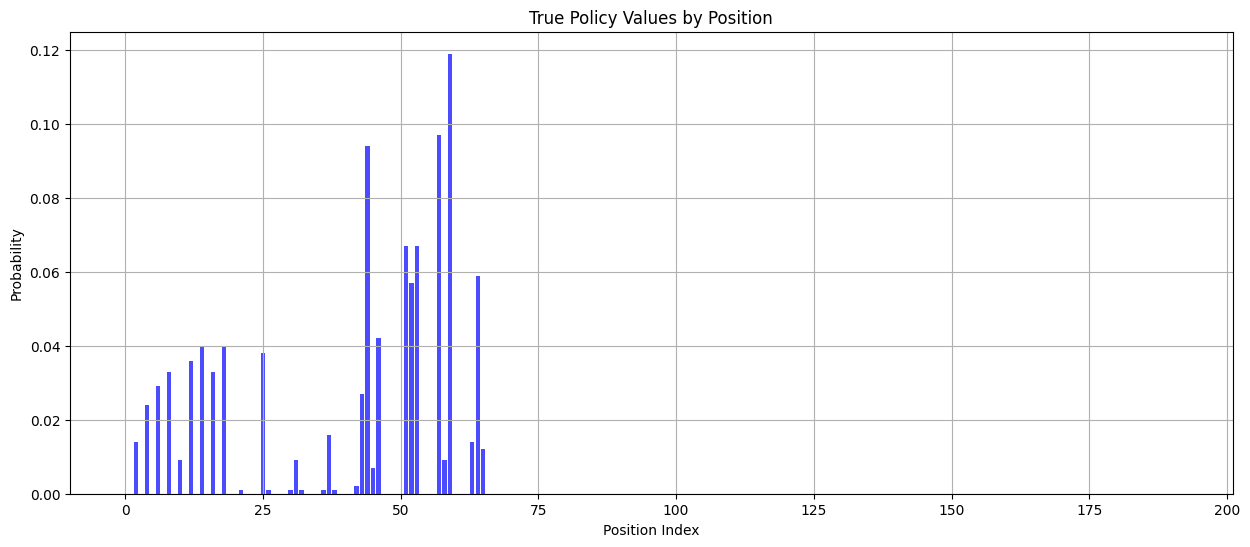

In [104]:
sum_of_values_true = sum(true_policy)

# Calculate the number of non-zero elements in the list
non_zero_count_true = sum(1 for value in true_policy if value != 0)

sum_of_values_true, non_zero_count_true


# Create a bar plot
indices = np.arange(len(true_policy))
plt.figure(figsize=(15, 6))
plt.bar(indices, true_policy, color='blue', alpha=0.7)
plt.title('True Policy Values by Position')
plt.xlabel('Position Index')
plt.ylabel('Probability')
plt.grid(True)
plt.show()

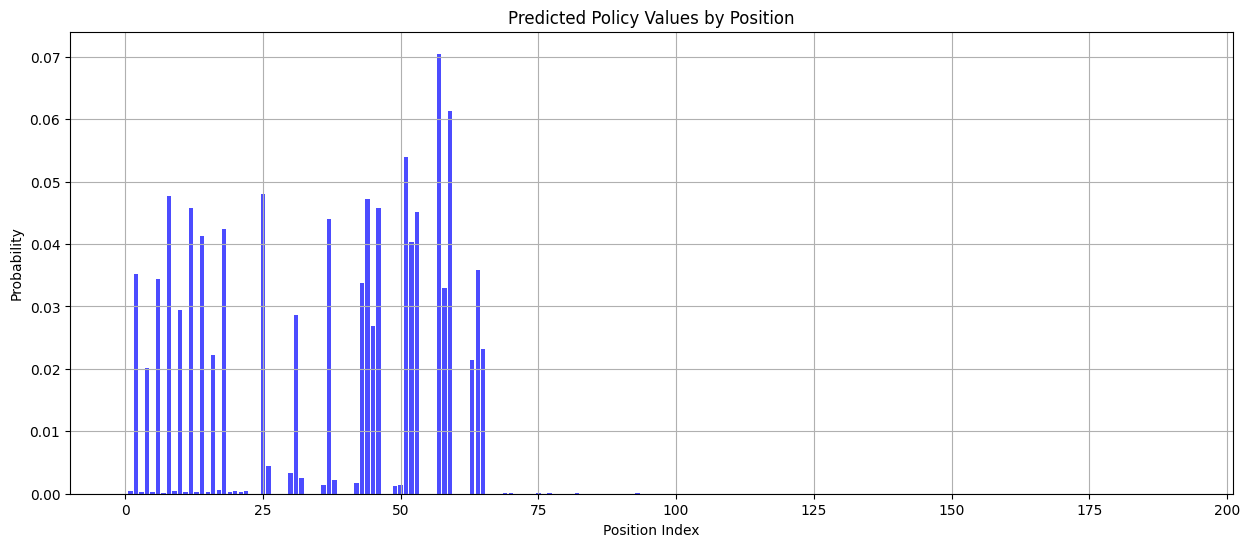

In [105]:
predicted_policy_flat = np.ravel(predicted_policy)
sum_of_values_pred = np.sum(predicted_policy_flat)

non_zero_count_pred = np.count_nonzero(predicted_policy_flat)
sum_of_values_pred, non_zero_count_pred

# Create a bar plot
indices = np.arange(len(predicted_policy_flat))
plt.figure(figsize=(15, 6))
plt.bar(indices, predicted_policy_flat, color='blue', alpha=0.7)
plt.title('Predicted Policy Values by Position')
plt.xlabel('Position Index')
plt.ylabel('Probability')
plt.grid(True)
plt.show()

In [91]:


def encode_board_state(board_state_str):
    board_array = np.zeros((8, 8, 3))
    for i, char in enumerate(board_state_str):
        row, col = divmod(i, 8)
        if char == 'w':
            board_array[row, col, 0] = 1
        elif char == 'b':
            board_array[row, col, 1] = 1
        else:
            board_array[row, col, 2] = 1
    return board_array

def map_policy_to_moves(policy_vector, possible_moves):

    move_policy_dict = {}
    total_policy_value = 0

    for move in possible_moves:
        old_pos = move[0]
        new_pos = move[1]
        index = calculate_move_index(old_pos, new_pos)
        move_policy_dict[move] = policy_vector[index]
        total_policy_value += policy_vector[index]

    # Normalize policy values
    for move in move_policy_dict:
        move_policy_dict[move] /= total_policy_value

    return move_policy_dict

def calculate_move_index(old_pos, new_pos):

    base_index = (old_pos[0] * 8 + old_pos[1]) * 3
    row_diff = new_pos[0] - old_pos[0]
    col_diff = new_pos[1] - old_pos[1]

    if row_diff == -1 or row_diff == 1:
        if col_diff == -1:
            return base_index + 0  # Diagonal left
        elif col_diff == 0:
            return base_index + 1  # Straight
        elif col_diff == 1:
            return base_index + 2  # Diagonal right
    return -1  # Invalid move




In [92]:
# Example board state string
board_state_str = "bbbbbb000bb0bbbb0w00000b0000b000000000b0000wwww0w000w0wwwwwwwww0"

# Example list of possible moves
possible_moves_str = "2,1:1,0;2,1:1,2;2,1:1,1;5,3:4,2;5,3:4,4;5,3:4,3;5,4:4,3;5,4:4,5;5,4:4,4;5,5:4,4;5,5:4,6;5,5:4,5;5,6:4,5;5,6:4,7;5,6:4,6;6,0:5,1;6,0:5,0;6,6:5,7;6,7:5,7;7,0:6,1;7,1:6,2;7,1:6,1;7,2:6,1;7,2:6,3;7,2:6,2;7,3:6,2;7,3:6,3;7,4:6,3;7,4:6,5;7,5:6,5;7,6:6,5;"
possible_moves = [((int(move.split(':')[0].split(',')[0]), int(move.split(':')[0].split(',')[1])),
                   (int(move.split(':')[1].split(',')[0]), int(move.split(':')[1].split(',')[1])))
                  for move in possible_moves_str.split(';') if move]


# Process the board state
board_state = encode_board_state(board_state_str)

# Add an additional dimension to represent batch size
board_state_batch = np.expand_dims(board_state, axis=0)

# Predict using the loaded model
predictions = loaded_model.predict(board_state_batch)
policy_vector, value = predictions[0][0], predictions[1][0]

# Map policy vector to moves
mapped_policy = map_policy_to_moves(policy_vector, possible_moves)

# Output the results for testing
print("Mapped Policy:")
for move, policy_value in mapped_policy.items():
    print(f"Move: {move}, Policy Value: {policy_value}")
print("Value: ", value)


1/1 [==============================] - 0s 306ms/step
Mapped Policy:
Move: ((2, 1), (1, 0)), Policy Value: 0.138066245350872
Move: ((2, 1), (1, 2)), Policy Value: 0.09816907503522838
Move: ((2, 1), (1, 1)), Policy Value: 0.18057620399167487
Move: ((5, 3), (4, 2)), Policy Value: 0.023328515322859563
Move: ((5, 3), (4, 4)), Policy Value: 0.013940728422052556
Move: ((5, 3), (4, 3)), Policy Value: 0.016246677798827224
Move: ((5, 4), (4, 3)), Policy Value: 0.012269601912108019
Move: ((5, 4), (4, 5)), Policy Value: 0.018759631694848806
Move: ((5, 4), (4, 4)), Policy Value: 0.016338567684898227
Move: ((5, 5), (4, 4)), Policy Value: 0.014957570072582329
Move: ((5, 5), (4, 6)), Policy Value: 0.009747018785200467
Move: ((5, 5), (4, 5)), Policy Value: 0.018553230926668104
Move: ((5, 6), (4, 5)), Policy Value: 0.011083935728311364
Move: ((5, 6), (4, 7)), Policy Value: 0.012083276294464457
Move: ((5, 6), (4, 6)), Policy Value: 0.009210874155664503
Move: ((6, 0), (5, 1)), Policy Value: 0.019815089468

In [ ]:
loaded_model.summary()